# Motor error analysis

## NOTE: Data is not currently shared. This code is only provided for reference.

Motor errors are the “expected” outcome when a person faces a perturbation to their normal course of movement. Usually, the expectation is that, with more experience, the person would adapt to the perturbation by reducing their error.

Here, we used resistive perturbations during recumbent stepping at different timings and compared the motor errors of young and older adults. We asked subjects to step smoothly (spatial constraint) and follow a one-step-per-second cadence (temporal constraint). We found that adaptation to the perturbation happened, not in the sense of reducing motor errors, but rather by going toward more significant errors. This was because the most critical factor for the subjects was time and their temporal errors, which they handily kept close to zero. Therefore, they did not seem to feel the urge (or get the feedback) to reduce their spatial motor errors, i.e., the smoothness of their stepping pattern.  We also found that older adults could reduce their errors more than young adults. We discuss the muscular implications of this behavior in the paper, where we also present the electromyography (EMG) and co-contraction results.

In [16]:
import os
import pickle as pkl

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin as pg
import ray
from matplotlib.colors import to_rgb as rgb
from scipy.io import loadmat

import lineNdots as lnd
import SMART_Funcs as SF

ray.shutdown()
ray.init(dashboard_host='127.0.0.1')
plot_fig, save_fig, save_stats = True, False, False

2022-11-15 02:16:00,113	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


In [9]:
# Set some variables
# young adults 17 subjects.
subjs = {'young': ["PS04", "PS05", "PS06", "PS07", "PS15", "PS16", "PS17", "PS18", "PS19", "PS20", "PS21", "PS22",
                   "PS23", "PS24", "PS25", "PS26", "PS27"],
         'old': ["PS08", "PS09", "PS10", "PS28", "PS29", "PS31", "PS32", "PS33", "PS34", "PS35", "PS36"]}
conds = ['LME', 'LEI', 'RME', 'REI']
analysis_type = ['duration_error', 'position_error']
data_path = './data/stepping/'
step_data = 'stepping_time_young-and-old.pickle'
error_data = 'motor_errors_young-and-old.pickle'
if not os.path.isdir(data_path + 'results'):
    os.mkdir(data_path + 'results')

# load motor error and stepping time data
step_time = pkl.load(open(data_path + step_data , 'rb'))
group_data = pkl.load(open(data_path + error_data, 'rb'))

In [10]:
# Separate the steps into pre, post, perturbations and catches
blocks = {'pre': [0], 'pert': [1, 3], 'catch': [2], 'post': [4]}
seperated_metrics = {c: {s: {b: pd.DataFrame for b in blocks} for a in subjs for s in subjs[a]} for c in conds}
for a in subjs:
    for s in subjs[a]:
        for c in conds:
            last_pert = step_time[c][s][[c in blocks['pert'] for c in step_time[c][s]['type']]].index[-1]
            step_time[c][s].loc[last_pert + 1:, 'type'] = 4
            if not bool(group_data[c][s].empty):
                for b in blocks:
                    seperated_metrics[c][s][b] = group_data[c][s][[t in blocks[b] for t in step_time[c][s]['type']]]

In [ ]:
# Put the steps into SMART compatible SHORT format
# See the SMART_oneSample_sectioned help for the SHORT and long format.
blocks = {'pre': [0], 'pert': [1, 3], 'catch': [2], 'post': [4]}
smart_cols = ['subj_no', 'stride_time'] + analysis_type  # columns needed for SMART
metric_short = {a: {c: {b: pd.DataFrame(columns=smart_cols) for b in blocks} for c in conds} for a in subjs}
for a in subjs:
    for c in conds:
        for i, s in enumerate(subjs[a]):
            for b in blocks:
                if not bool(group_data[c][s].empty):
                    temp_metric = group_data[c][s][[t in blocks[b] for t in step_time[c][s]['type']]]
                    temp_time = step_time[c][s][[t in blocks[b] for t in step_time[c][s]['type']]]
                    temp_df = {'subj_no': i, 'stride_time': temp_time['start'].values.flatten()}
                    temp_errors = {t: temp_metric.loc[:, t] for t in analysis_type}
                    temp_df.update(temp_errors)
                    metric_short[a][c][b] = metric_short[a][c][b].append(temp_df, ignore_index=True)

## SMART smoothing
We use the `SMART` toolbox to make a smooth average of the group data with the desired temporal kernel ans step sizes. You can change the `kernel_size` and `step_size` to make get a desired smoothed groupped results. This method has several advantages over the common binning approaches that you can read in SMART paper.

We also use the `Ray` toolbox to parallelize the processing. It turns out the with smaller kernel sizes (for example for what is shown in the Figure 2 of the paper), there is considerbale demand for processing power. With Python lacking mutlihtreading/processing out of the box, there are several toolbixes that provide this capability for Python, and especailly the scientific stack.

Note: to get the figure 2, re-run this spcript with `step_size = 6`

In [12]:
# Fixed macros and pre-allocate variables for SMART
# fixed macros
time_var = 'stride_time'  # short format file spec
# min and max time stamps for the different blocks
time_lim = {'pre': [0, 120], 'pert': [120, 480], 'catch': [120, 480], 'post': [480, 600]}
kernel_size, step_size = 16, 60  # smoothing params
n_perms, baseline = 1000, 0  # permutation params
sig_level = 0.05  # stats params
l_color = {a: [] for a in subjs}
l_color['young'] = {'pre': rgb('lime'), 'pert': rgb('dodgerblue'), 'catch': rgb('deeppink'), 'post': rgb('darkgreen')}
l_color['old'] = {'pre': rgb('orange'), 'pert': rgb('royalblue'), 'catch': rgb('darkviolet'),
                  'post': rgb('darkgoldenrod')}
# plotting params. "l": line, "m": marker, "hist_res": histogram resolution for permutation the distribution plot.
l_width, ma_offset, m_size, label_size, hist_res = 2, 0.75, 10, 20, 100

# pre-allocate variables
no_subjs = {a: {c: {b: len(metric_short[a][c][b]) for b in blocks} for c in conds} for a in subjs}
all_times = {a: {c: {b: np.hstack(metric_short[a][c][b][time_var]) for b in blocks} for c in conds} for a in subjs}
time_vect = {b: np.arange(time_lim[b][0], time_lim[b][1], step_size) for b in blocks}
timeVect_ray = {b: ray.put(time_vect[b]) for b in blocks}
# smoothed data and weights
sm_data, sm_weights = [{a: {c: {b: {t: np.zeros((no_subjs[a][c][b], len(time_vect[b]))) for t in analysis_type}
                                for b in blocks} for c in conds} for a in subjs} for _ in range(2)]
# permutation data and weights.
perm_d1, perm_w1, perm_d2, perm_w2 = [{a: {c: {b: {t: np.zeros((no_subjs[a][c][b], len(time_vect[b]), n_perms))
                                                   for t in analysis_type} for b in blocks} for c in conds}
                                       for a in subjs} for _ in range(4)]

sm_id, pm_id = [{a: {c: {b: {i: {t: [] for t in analysis_type} for i in np.arange(no_subjs[a][c][b])}
                         for b in blocks} for c in conds} for a in subjs} for _ in range(2)]

par_smooth = ray.remote(SF.gaussSmooth)
par_permute = ray.remote(SF.permute)

# Run smoothing and permutation
for a in subjs:
    for c in conds:
        for b in blocks:
            for i in np.arange(no_subjs[a][c][b]):
                for t in analysis_type:
                    sm_id[a][c][b][i][t] = par_smooth.remote(
                        metric_short[a][c][b][time_var][i], metric_short[a][c][b][t][i], timeVect_ray[b], kernel_size)
                    pm_id[a][c][b][i][t] = par_permute.remote(
                        metric_short[a][c][b][time_var][i], metric_short[a][c][b][t][i], newX=timeVect_ray[b],
                        sigma=kernel_size, nPerms=n_perms, baseline=baseline)
# sanity check: serial running for the sake of debugging
                    # sm_data[c][b][t][i, :], sm_weights[c][b][t][i, :] = SF.gaussSmooth(
                    #     metric_short[c][b][time_var][i], metric_short[c][b][t][i], time_vect[b], kernel_size)
                    # (perm_d1[c][b][t][i, :, :], perm_w1[c][b][t][i, :, :],
                    # perm_d2[c][b][t][i, :, :], perm_w2[c][b][t][i, :, :]) = SF.permute(
                    #     metric_short[c][b][time_var][i], metric_short[c][b][t][i], newX=time_vect[b],
                    #     sigma=kernel_size, nPerms=n_perms, baseline=baseline)

In [13]:
# Get the Ray results
for a in subjs:
    for c in conds:
        for b in blocks:
            for i in np.arange(no_subjs[a][c][b]):
                for t in analysis_type:
                    try:
                        sm_id[a][c][b][i][t] = ray.get(sm_id[a][c][b][i][t])
                        sm_data[a][c][b][t][i, :] = sm_id[a][c][b][i][t][0]
                        sm_weights[a][c][b][t][i, :] = sm_id[a][c][b][i][t][1]
                    except Exception:
                        print(f'smoothing failed for subject{i}_{c}_{b}_{t} in the {a} group')
                    try:
                        pm_id[a][c][b][i][t] = ray.get(pm_id[a][c][b][i][t])
                        (perm_d1[a][c][b][t][i, :, :], perm_w1[a][c][b][t][i, :, :], perm_d2[a][c][b][t][i, :, :],
                        perm_w2[a][c][b][t][i, :, :]) = [pm_id[a][c][b][i][t][k] for k in range(4)]
                    except Exception:
                        print(f'permutation failed for subject{i}_{c}_{b}_{t} in the {a} group')
del pm_id, sm_id  # deleting is required to free up space from RAY processing

In [14]:
# Run the statistics
weighted_average, weight_sum, sigInd_inClust, ensemTval_inClust, conf95, perm_distr, sig_ther, stat_id = [
    {a: {c: {b: [] for b in blocks} for c in conds} for a in subjs} for _ in range(8)]


@ray.remote
def run_stats(sm_data, sm_weights, perm_d1, perm_d2, perm_w1, perm_w2, analysis_type, baseline):

    weighted_average, weights, sigInd_inClust, ensemTval_inClust, conf95, perm_distr, sig_ther = [
        {t: [] for t in analysis_type} for _ in range(7)]

    for t in analysis_type:
        weighted_average[t], weights[t] = np.average(sm_data[t], weights=sm_weights[t], axis=0, returned=True)
        sigInd_inClust[t], ensemTval_inClust[t] = SF.clusterStat_oneSamp(
            sm_data[t], sm_weights[t], baseline[t], sig_level)
        conf95[t] = SF.weighConfOneSample95(sm_data[t], sm_weights[t])
        perm_distr[t] = SF.permuteClusterStat(perm_d1[t], perm_d2[t], perm_w1[t], perm_w2[t], sig_level)
        sig_ther[t] = np.percentile(perm_distr[t], 100 - (sig_level * 100))
    return weighted_average, weights, sigInd_inClust, ensemTval_inClust, conf95, perm_distr, sig_ther


for a in subjs:
    for c in conds:
        for b in blocks:
            # d_baseline = {'duration_error': sm_data[a][c][b]['duration_error'].mean(),
            # 'position_error': sm_data[a][c][b]['position_error'].mean()}
            d_baseline = {'duration_error': 0, 'position_error': 0}

            stat_id[a][c][b] = run_stats.remote(
                sm_data[a][c][b], sm_weights[a][c][b], perm_d1[a][c][b], perm_d2[a][c][b],
                perm_w1[a][c][b], perm_w2[a][c][b], analysis_type, d_baseline)
for a in subjs:
    for c in conds:
        for b in blocks:
            stat_id[a][c][b] = ray.get(stat_id[a][c][b])
            (weighted_average[a][c][b], weight_sum[a][c][b], sigInd_inClust[a][c][b], ensemTval_inClust[a][c][b],
            conf95[a][c][b], perm_distr[a][c][b], sig_ther[a][c][b]) = [stat_id[a][c][b][i] for i in range(7)]

In [15]:
# Compare the catches to the perturbations
paired_comps = {'pert-catch': ['pert', 'catch'], 'pre-post': ['pre', 'post']}
cl_sig, cl_ensemT, cl_permDist, cl_sigTher, cl_conf95, stat_id = [
    {a: {c: {pc: [] for pc in paired_comps} for c in conds} for a in subjs} for _ in range(6)]


# @ray.remote
def run_pairedStats(
    sm_data1, sm_data2, sm_weights1, sm_weights2, perm_d1, perm_d2, perm_w1, perm_w2, analysis_type, sig_level=0.05):

    sigInd_inClust, ensemTval_inClust, conf95, perm_distr, sig_ther = [{t: [] for t in analysis_type} for _ in range(5)]
    for t in analysis_type:
        sigInd_inClust[t], ensemTval_inClust[t] = SF.clusterStat_rel(
            sm_data1[t], sm_data2[t], sm_weights1[t], sm_weights2[t], sig_level)
        perm_distr[t] = SF.permuteClusterStat(perm_d1[t], perm_d2[t], perm_w1[t], perm_w2[t], sig_level)
        sig_ther[t] = np.percentile(perm_distr[t], 100 - (sig_level * 100))
        conf95[t] = SF.weighPairedConf95(sm_data1[t], sm_data2[t], sm_weights1[t], sm_weights2[t])
    return sigInd_inClust, ensemTval_inClust, conf95, perm_distr, sig_ther


# sanity check
for a in subjs:
    for c in conds:
        for pc in paired_comps:
            (cl_sig[a][c][pc], cl_ensemT[a][c][pc], cl_conf95[a][c][pc], cl_permDist[a][c][pc],
            cl_sigTher[a][c][pc]) = run_pairedStats(
                sm_data[a][c][paired_comps[pc][0]], sm_data[a][c][paired_comps[pc][1]],
                sm_weights[a][c][paired_comps[pc][0]], sm_weights[a][c][paired_comps[pc][1]],
                perm_d1[a][c][paired_comps[pc][0]], perm_d1[a][c][paired_comps[pc][1]],
                perm_w1[a][c][paired_comps[pc][0]], perm_w1[a][c][paired_comps[pc][1]], analysis_type)

/var/folders/9f/k71kd7t17yn7055lxp4vg2lc0000gn/T/ipykernel_46340/102639595.py:34: UserWarning: Legend does not support [] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  fig.legend([line['young'], line['old']], ['young', 'old'], loc='upper right')


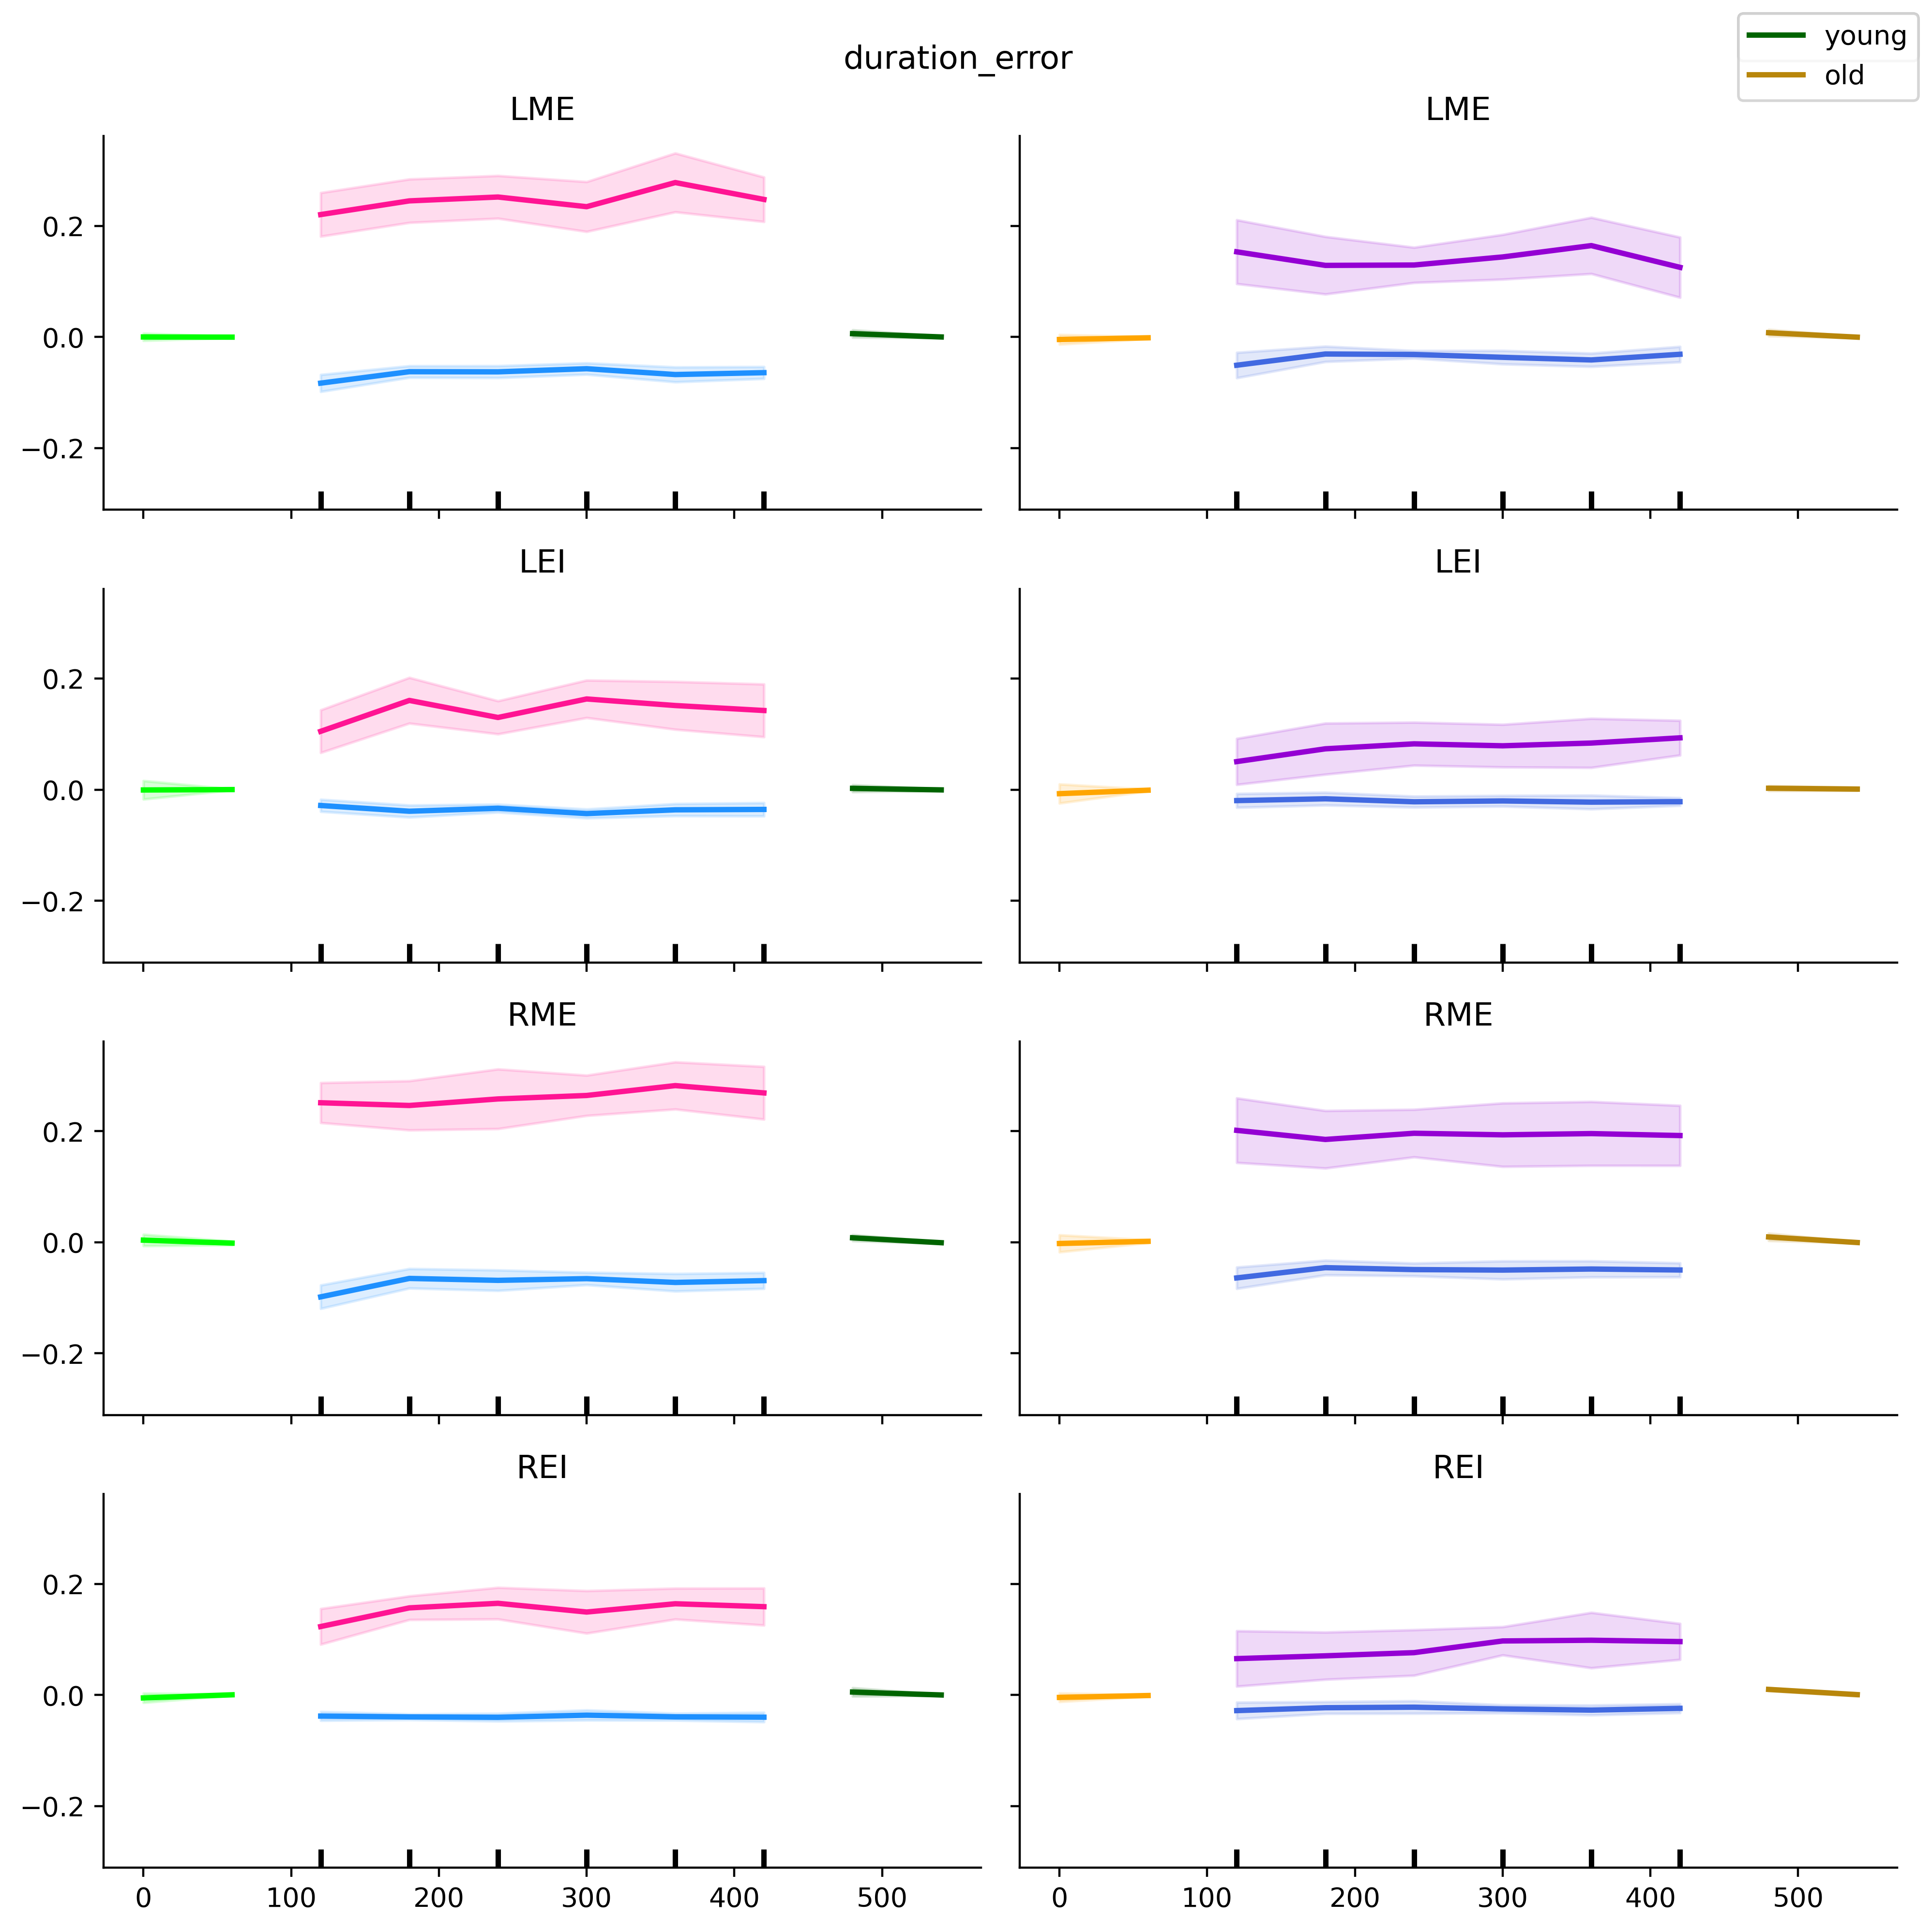

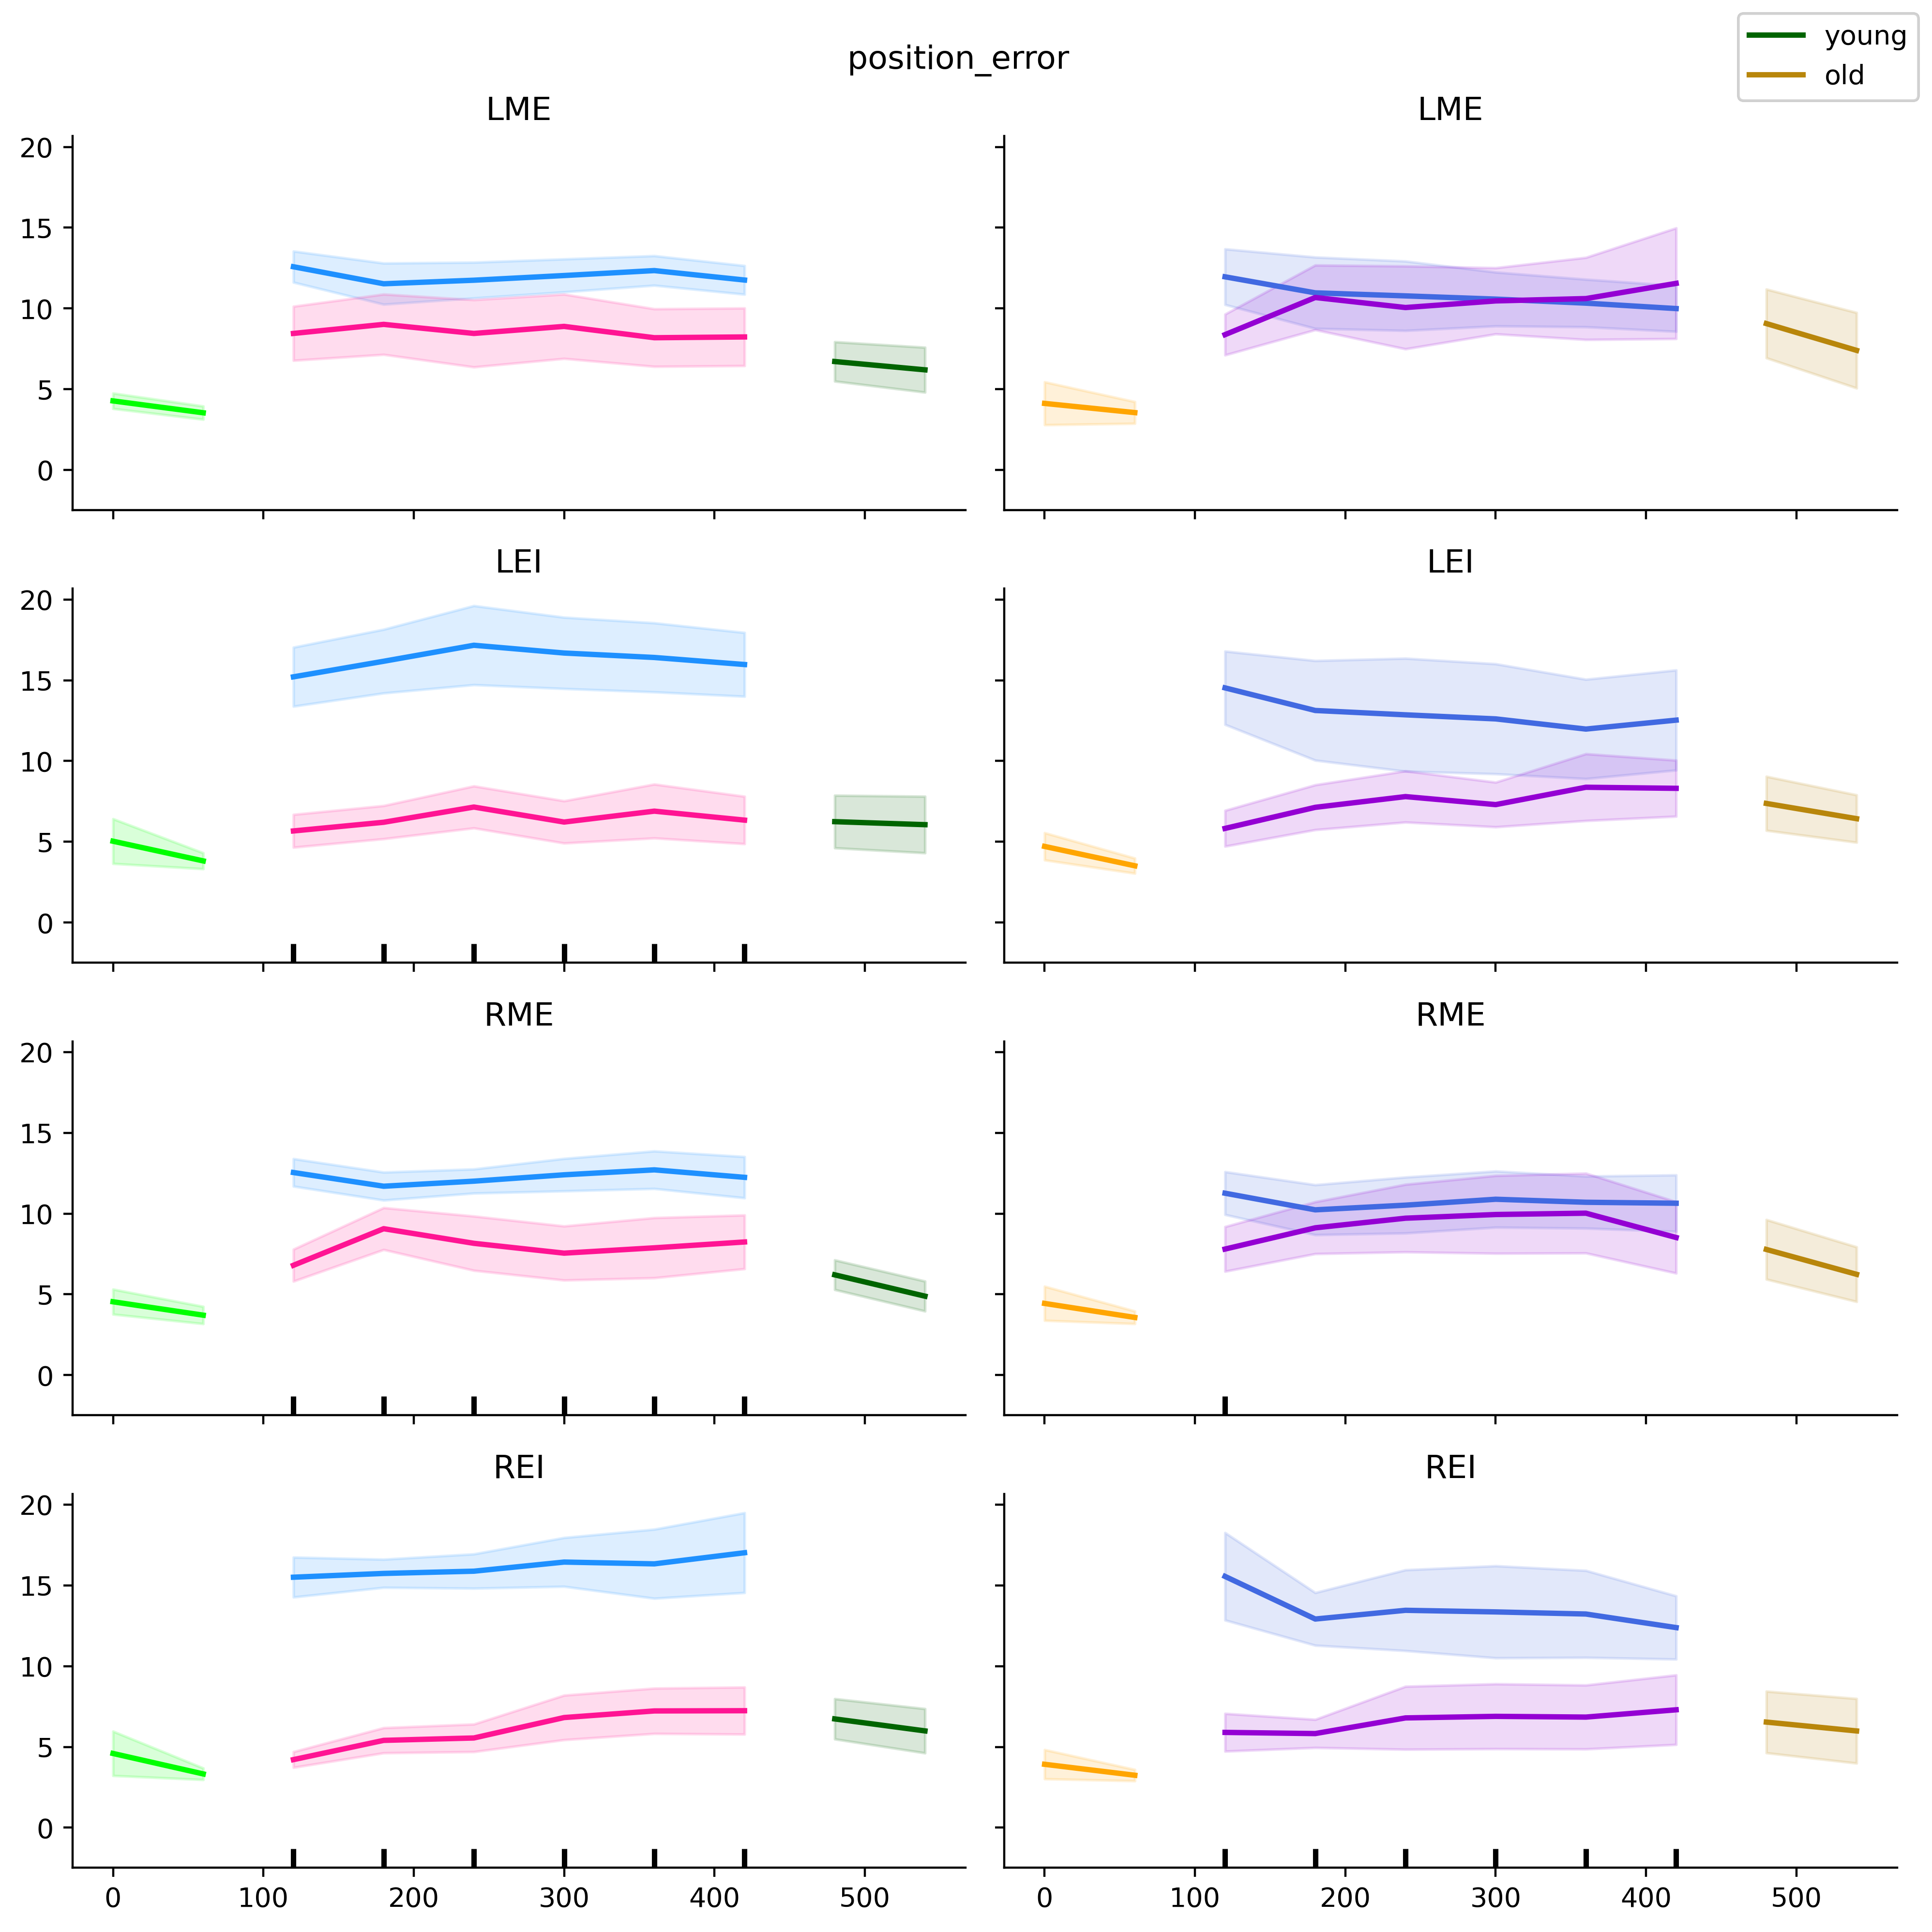

In [17]:
# %% plot
# There are some implicit assumptions here based on my use case. Please modify the code for your wn purpose.
ensem_xRange = [t for ts in list(time_lim.values()) for t in ts]
ensemBase_x = np.arange(min(ensem_xRange), max(ensem_xRange))
base_y = np.zeros(len(ensemBase_x)) + baseline
line = {'young': [], 'old': []}

for t in analysis_type:
    fig, ax = plt.subplots(len(conds), len(subjs), sharex=True, sharey=True, squeeze=False, figsize=(10, 10), dpi=400)
    # ax = ax.reshape(np.size(ax))  # this changes makes a row of axes
    for j, a in enumerate(subjs):
        for i, c in enumerate(conds):
            for b in blocks:
                line[a], = ax[i, j].plot(
                    time_vect[b], weighted_average[a][c][b][t], color=l_color[a][b], linewidth=l_width)
                ax[i, j].set_title(c)
                ax[i, j].fill_between(
                    time_vect[b], weighted_average[a][c][b][t] - conf95[a][c][b][t],
                    weighted_average[a][c][b][t] + conf95[a][c][b][t], color=l_color[a][b], alpha=0.15)
                if b == 'pert':
                    for sdx, s in enumerate(cl_sig[a][c]['pert-catch'][t]):
                        if cl_ensemT[a][c]['pert-catch'][t][sdx] > cl_sigTher[a][c]['pert-catch'][t]:
                            sns.rugplot(time_vect[b][s], height=.05, ax=ax[i, j],
                                        linewidth=2, color=rgb('black'), expand_margins=False)
                ax[i, j].spines['right'].set_visible(False)
                ax[i, j].spines['top'].set_visible(False)
                # ax[i,j].set_ylim(-.2,1.5)
                # if b == 'post':
                #     for sdx, s in enumerate(sigInd_inClust[a][c][b][t]):
                #         if ensemTval_inClust[a][c][b][t][sdx] > sig_ther[a][c][b][t]:
                #             sns.rugplot(time_vect[b][s],height=.05, ax=ax[i,j],linewidth=2, color=rgb('black'))
        fig.tight_layout()
        fig.suptitle(t)
        fig.legend([line['young'], line['old']], ['young', 'old'], loc='upper right')
        if save_fig:
            fig.savefig(data_path + 'group_response/motorError_' + t + '_youngOld.pdf')
            fig.savefig(data_path + 'group_response/motorError_' + t + '_youngOld.jpg')

In [ ]:
# rANOVA for error SMART plots
stat_cols = ['pre', 'early_pert', 'late_pert', 'early_catch', 'late_catch', 'early_post', 'late_post']
apriori_comps = [['pre', 'late_post'], ['early_pert', 'late_pert'], ['early_catch', 'late_catch'],
                 ['early_post, late_post']]


def findIn_posthoc(a, b, apriori):
    c = []
    for ii, i in enumerate(a):
        for j in apriori:
            if i in j and b[ii] in j:
                c += [ii]
    return c


stat_data = {t: {a: {c: pd.DataFrame(columns=stat_cols) for c in conds} for a in subjs} for t in analysis_type}
rm, post = [{t: {a: {c: [] for c in conds} for a in subjs} for t in analysis_type} for _ in range(2)]
significant_rm = pd.DataFrame(columns=['test'])
significant_post = pd.DataFrame(columns=['test'])
for t in analysis_type:
    for a in subjs:
        for c in conds:
            for i, s in enumerate(subjs[a]):
                try:
                    temp_data = {}
                    for b in blocks:
                        try:
                            if b == 'pre':
                                temp_data[b] = (sm_data[a][c][b][t][i][-1] * sm_weights[a][c][b][t][i][-1] /
                                                weight_sum[a][c][b][t][-1])
                            else:
                                temp_data['early_' + b] = (sm_data[a][c][b][t][i][1] * sm_weights[a][c][b][t][i][1] /
                                weight_sum[a][c][b][t][1])
                                temp_data['late_' + b] = (sm_data[a][c][b][t][i][-1] * sm_weights[a][c][b][t][i][-1] /
                                weight_sum[a][c][b][t][-1])
                        except Exception:
                            pass
                    stat_data[t][a][c] = stat_data[t][a][c].append(temp_data, ignore_index=True)
                except Exception:
                    pass
            rm[t][a][c] = pg.rm_anova(stat_data[t][a][c])
            if rm[t][a][c]['p-unc'][0] < 0.05:
                print(f'{t}_{a}_{c} is significant')
                significant_rm = significant_rm.append(rm[t][a][c], ignore_index=True)
                significant_rm['test'].iloc[-1] = f'{t}_{a}_{c}'
                post[t][a][c] = stat_data[t][a][c].assign(
                    idx=stat_data[t][a][c].index).melt(id_vars='idx').pairwise_ttests(
                        dv='value', within='variable', subject='idx')
                post[t][a][c]['test'] = f'{t}_{a}_{c}'
                aa = post[t][a][c][post[t][a][c]['p-unc'] < 0.07].loc[:, 'A'].to_list()
                bb = post[t][a][c][post[t][a][c]['p-unc'] < 0.07].loc[:, 'B'].to_list()
                significant_post = significant_post.append(
                    post[t][a][c][post[t][a][c]['p-unc'] < 0.07].iloc[findIn_posthoc(aa, bb, apriori_comps), :],
                    ignore_index=True)
# with pd.ExcelWriter(data_path+'group_response/motorError_repeatedMeasures_significantStat.xlsx') as writer:
#     significant_rm.to_excel(writer, sheet_name='rANOVA')
#     significant_post.to_excel(writer, sheet_name='paired_ttest')

# %% compare young vs old
# Error plots should have a similar to what we have with the coContraction, especially about the summary plot per
# minute.

# weight normalization
# Part of the smoothing was to find the weight of each data point, so, we cant' just add them together and make an
#  average. First we need to embed the weights into the CI values.
NUM_COL = 10
DES_POINTS = {'pre': 2, 'pert': 6, 'catch': 6, 'post': 2}


def normalize_by_weight(data, weights, axis=0):
    data = data * weights / np.tile(np.sum(weights, axis=axis), [data.shape[axis], 1]) * data.shape[axis]
    return data


normal_average = {t: {a: {c: np.zeros([len(subjs[a]), NUM_COL]) for c in conds}
                  for a in subjs} for t in analysis_type}
for k, t in enumerate(analysis_type):
    for a in subjs:
        for c in conds:
            count = 0
            for b in blocks:
                if b != 'catch':
                    temp_average = normalize_by_weight(
                        sm_data[a][c][b][t], sm_weights[a][c][b][t], axis=0)
                    for j in range(temp_average.shape[0]):
                        normal_average[t][a][c][j, count: count + DES_POINTS[b]] = temp_average[j, :]
                    count += DES_POINTS[b]
            normal_average[t][a][c][normal_average[t][a][c] == 0] = np.nan

# stats
error_stats = {t: pd.DataFrame() for t in analysis_type}
for t in analysis_type:
    for i, c in enumerate(conds):
        for n in range(NUM_COL):
            temp_test = pg.ttest(
                normal_average[t]['young'][c][:, n], normal_average[t]['old'][c][:, n], correction=False)
            error_stats[t] = pd.concat([error_stats[t], temp_test], ignore_index=True)
            error_stats[t].loc[i * NUM_COL + n, 'condition'] = f'{c}_{n}'

if save_stats:
    with pd.ExcelWriter(data_path + 'group_response/error_per_min_stats.xlsx') as writer:
        for t in analysis_type:
            error_stats[t][error_stats[t]['p-val'] < 0.1].to_excel(writer, sheet_name=t)


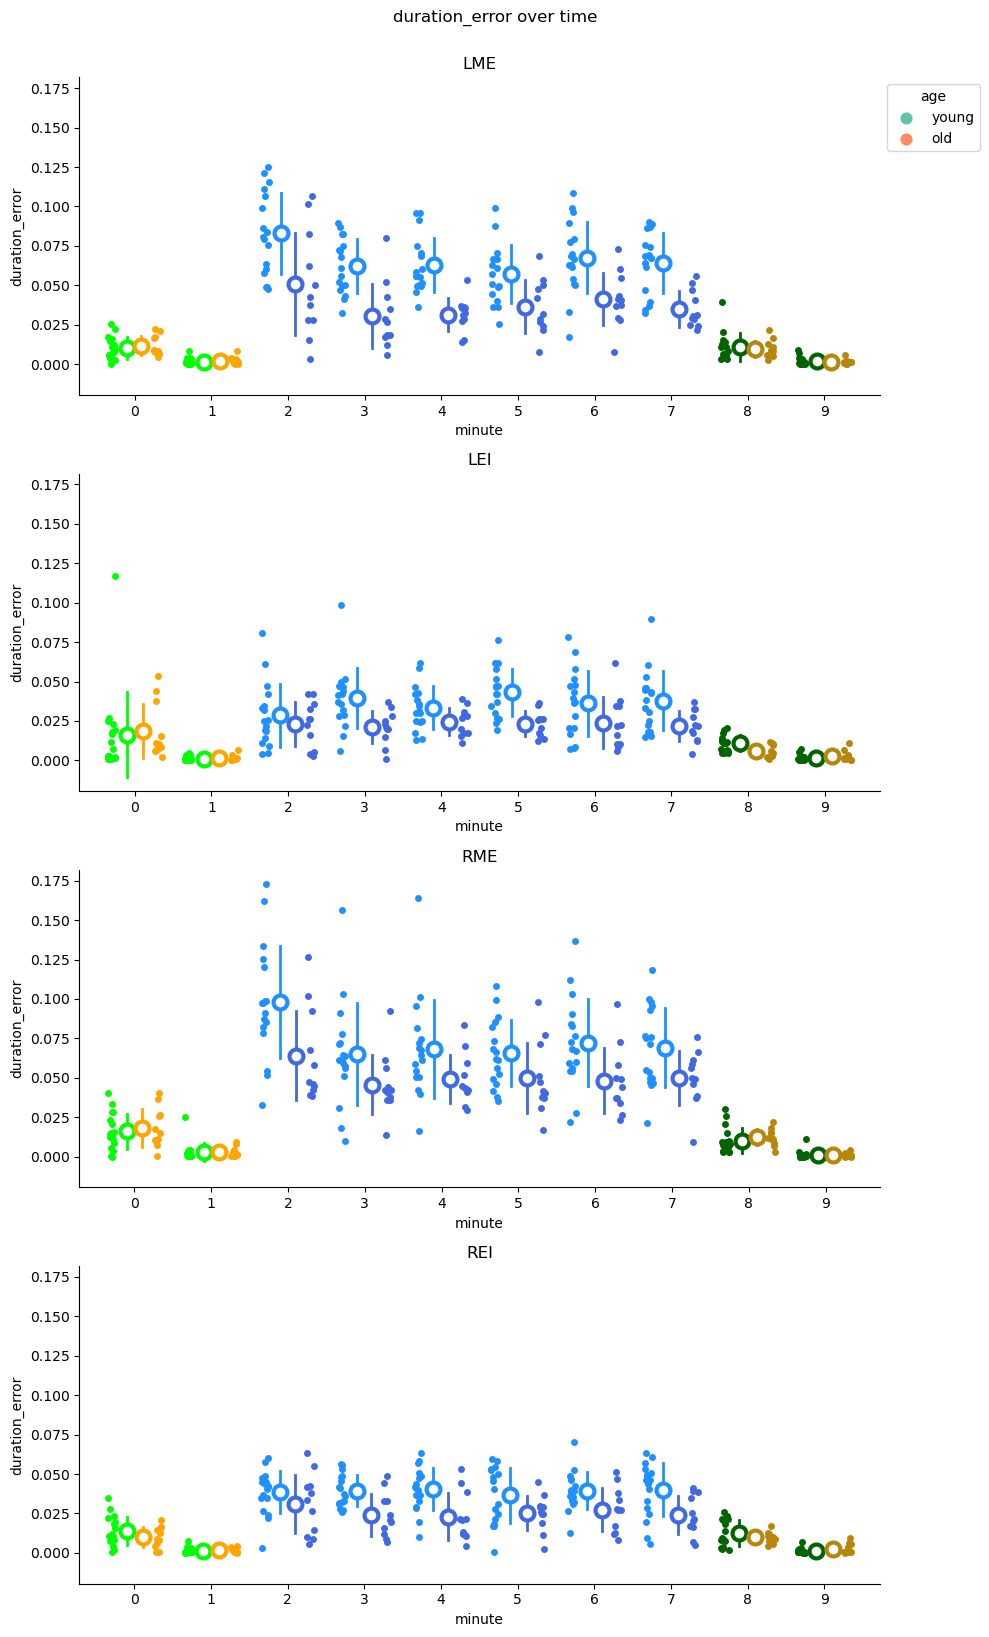

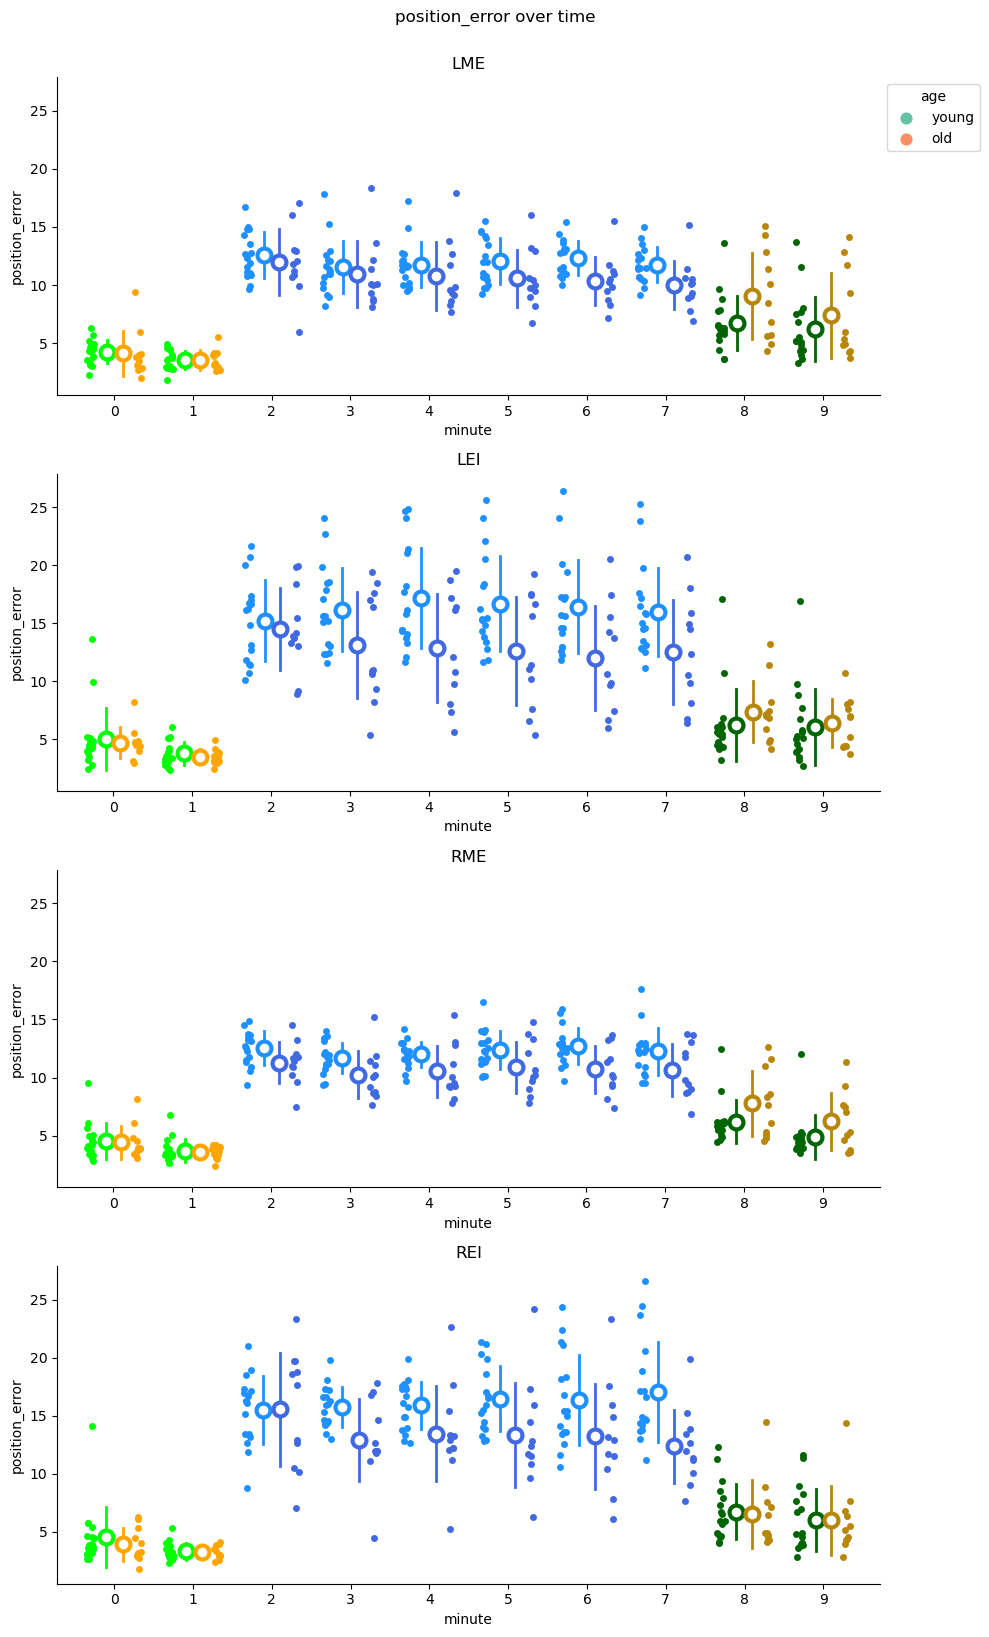

In [19]:
# Collapse over time
# We can try to find the resiting ratio for 1- each time-frame and then for the overall. This way, we only collapse the
# the muscles, not the time
plot_colors = {'young':
               np.concatenate((
                   np.tile(l_color['young']['pre'], (2, 1)),
                   np.tile(l_color['young']['pert'], (6, 1)),
                   np.tile(l_color['young']['post'], (2, 1))), axis=0),
               'old':
               np.concatenate((
                   np.tile(l_color['old']['pre'], (2, 1)),
                   np.tile(l_color['old']['pert'], (6, 1)),
                   np.tile(l_color['old']['post'], (2, 1))), axis=0)}

box_data = {t: {c: [] for c in conds} for t in analysis_type}
for t in analysis_type:
    fig, ax = plt.subplots(len(conds), 1, sharey=True, figsize=(10, 16))
    for i, c in enumerate(conds):
        box_data[t][c] = pd.DataFrame(normal_average[t]['young'][c]).abs()
        box_data[t][c]['age'] = 'young'
        box_data[t][c] = pd.concat([box_data[t][c], pd.DataFrame(normal_average[t]['old'][c]).abs()], ignore_index=True)
        box_data[t][c].loc[box_data[t][c]['age'] != 'young', 'age'] = 'old'
        lnd.lnd(
            data=box_data[t][c].melt(
                id_vars=['age'], value_vars=list(range(NUM_COL)), var_name='minute', value_name=t),
            x='minute', y=t, hue='age', palette='Set2', ax=ax[i], colors=plot_colors
            # split=True, inner='point'
        )
        sns.move_legend(ax[i], 'upper left', bbox_to_anchor=(1, 1))
        ax[i].set_title(c)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
        ax[i].get_legend().set_visible(False)
        if i == 0:
            ax[i].get_legend().set_visible(True)
    fig.tight_layout()
    fig.suptitle(t + ' over time', y=1.02)
    if not plot_fig:
        plt.close(fig)
    if save_fig:
        fig.savefig(data_path + 'group_response/' + t + '_by_time_and_age.pdf', bbox_inches='tight')